# Exploración y Procesamiento de Datos

En esta notebook, estaremos explorando nuestros datos, abordando las siguientes áreas clave:

* **Exploración de la Estructura de los Datos**: Analizaremos las columnas, los tipos de datos y la cantidad de registros para comprender la estructura de nuestros datos.

* **Análisis de Valores Faltantes y Calidad de los Datos**: Identificaremos cualquier valor faltante o dato inválido para asegurar la integridad y confiabilidad de nuestros datos.

* **Procesamiento de los Datos**: Realizaremos transformaciones necesarias para corregir problemas identificados y facilitar futuras manipulaciones de los datos.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array, concat, lit, countDistinct


import os, sys

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)
from src.tools import get_unique_vals, get_mes_numerico


data_path = os.path.join(root_path, 'data')

findspark.init()
spark = SparkSession.builder \
    .appName("Exploración de Datos AlgoSeguros") \
    .getOrCreate()


In [4]:
df = spark.read.csv(os.path.join(data_path, 'raw', 'IDM_NM_ene24.csv'), header=True, inferSchema=True, encoding="latin1")
df.printSchema()

root
 |-- Año: integer (nullable = true)
 |-- Clave_Ent: integer (nullable = true)
 |-- Entidad: string (nullable = true)
 |-- Cve. Municipio: integer (nullable = true)
 |-- Municipio: string (nullable = true)
 |-- Bien jurídico afectado: string (nullable = true)
 |-- Tipo de delito: string (nullable = true)
 |-- Subtipo de delito: string (nullable = true)
 |-- Modalidad: string (nullable = true)
 |-- Enero: integer (nullable = true)
 |-- Febrero: integer (nullable = true)
 |-- Marzo: integer (nullable = true)
 |-- Abril: integer (nullable = true)
 |-- Mayo: integer (nullable = true)
 |-- Junio: integer (nullable = true)
 |-- Julio: integer (nullable = true)
 |-- Agosto: integer (nullable = true)
 |-- Septiembre: integer (nullable = true)
 |-- Octubre: integer (nullable = true)
 |-- Noviembre: integer (nullable = true)
 |-- Diciembre: integer (nullable = true)



In [5]:
df.show(5)

+----+---------+--------------+--------------+--------------+----------------------+--------------+-----------------+-----------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
| Año|Clave_Ent|       Entidad|Cve. Municipio|     Municipio|Bien jurídico afectado|Tipo de delito|Subtipo de delito|        Modalidad|Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre|
+----+---------+--------------+--------------+--------------+----------------------+--------------+-----------------+-----------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|2015|        1|Aguascalientes|          1001|Aguascalientes|  La vida y la Inte...|     Homicidio| Homicidio doloso|Con arma de fuego|    2|      0|    1|    1|   0|    1|    1|     0|         2|      1|        0|        1|
|2015|        1|Aguascalientes|          1001|Aguascalientes|  La vida y la Inte...|     Homicidio| 

In [6]:
df.count()

2319072

Los datos contienen información sobre el registro de delitos por municipio, entidad federativa, mes y año en México desde 2015. La información proporcionada se refiere al tipo de delito, subtipo de delito, bien jurídico afectado y modalidad. A continuación, continuaremos explorando más sobre el contenido y la calidad de estos datos.

Dado que para nuestro problema únicamente necesitamos los delitos de robo que afectan al bien jurídico 'El patrimonio', vamos a filtrar los datos dejando únicamente los que son de nuestro interés. Sin embargo, antes de hacerlo, revisemos qué valores hay en las variables a filtrar y si no hay problemas con la calidad de estos.

In [7]:
from src.tools import get_unique_vals

get_unique_vals(df, 'Bien jurídico afectado')

['El patrimonio',
 'Libertad personal',
 'La sociedad',
 'Otros bienes jurídicos afectados (del fuero común)',
 'La vida y la Integridad corporal',
 'La libertad y la seguridad sexual',
 'La familia']

In [8]:
get_unique_vals(df, 'Tipo de delito')

['Abuso sexual',
 'Fraude',
 'Tráfico de menores',
 'Allanamiento de morada',
 'Violencia familiar',
 'Otros delitos que atentan contra la vida y la integridad corporal',
 'Violencia de género en todas sus modalidades distinta a la violencia familiar',
 'Otros delitos contra la sociedad',
 'Delitos cometidos por servidores públicos',
 'Abuso de confianza',
 'Acoso sexual',
 'Otros delitos contra la familia',
 'Otros delitos contra el patrimonio',
 'Falsedad',
 'Daño a la propiedad',
 'Falsificación',
 'Despojo',
 'Secuestro',
 'Incesto',
 'Violación equiparada',
 'Trata de personas',
 'Evasión de presos',
 'Otros delitos que atentan contra la libertad personal',
 'Corrupción de menores',
 'Rapto',
 'Violación simple',
 'Lesiones',
 'Narcomenudeo',
 'Incumplimiento de obligaciones de asistencia familiar',
 'Aborto',
 'Robo',
 'Extorsión',
 'Hostigamiento sexual',
 'Feminicidio',
 'Electorales',
 'Otros delitos del Fuero Común',
 'Otros delitos que atentan contra la libertad y la segurid

In [10]:
get_unique_vals(df.filter(col('Tipo de delito') == "Robo"), 'Bien jurídico afectado')

['El patrimonio']

In [11]:
get_unique_vals(df.filter(col('Bien jurídico afectado') == "El patrimonio"), 'Tipo de delito')

['Fraude',
 'Abuso de confianza',
 'Otros delitos contra el patrimonio',
 'Daño a la propiedad',
 'Despojo',
 'Robo',
 'Extorsión']

Los datos parecen tener sentido. La relación del tipo de delito 'Robo' es única al bien afectado 'El Patrimonio'. Por otro lado, la relación inversa no es única, ya que hay más delitos que afectan este bien jurídico, como Fraude, Daños a la Propiedad, etc. Ninguno de estos delitos parece tener algún error de escritura y se ve claramente que son categorías distintas. Comprobado esto, filtremos únicamente lo que nos interesa.

In [12]:
df = df.filter(
    (col('Bien jurídico afectado') == "El patrimonio") & \
    (col('Tipo de delito') == "Robo")
)
df = df.drop(col('Bien jurídico afectado'), col('Tipo de delito'))

In [13]:
df.show(5)

+----+---------+--------------+--------------+--------------+--------------------+--------------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
| Año|Clave_Ent|       Entidad|Cve. Municipio|     Municipio|   Subtipo de delito|           Modalidad|Enero|Febrero|Marzo|Abril|Mayo|Junio|Julio|Agosto|Septiembre|Octubre|Noviembre|Diciembre|
+----+---------+--------------+--------------+--------------+--------------------+--------------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|2015|        1|Aguascalientes|          1001|Aguascalientes|Robo a casa habit...|       Con violencia|    4|      3|    0|    7|   4|    6|    4|     3|         4|      1|        4|        7|
|2015|        1|Aguascalientes|          1001|Aguascalientes|Robo a casa habit...|       Sin violencia|  172|    151|  181|  155| 170|  182|  173|   168|       158|    144|      201|      171|
|2015|        1|Aguascalientes|    

Vamos a renombrar las columnas con la intención de eliminar espacios o caracteres potencialmente problemáticos.

In [14]:
new_cols = {column_name : column_name.replace(' ', '_').replace('.', '').strip().lower() for column_name in  df.columns}
for old_name, new_name in new_cols.items():
    df = df.withColumnRenamed(old_name, new_name)

In [15]:
df.show(5)

+----+---------+--------------+-------------+--------------+--------------------+--------------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
| año|clave_ent|       entidad|cve_municipio|     municipio|   subtipo_de_delito|           modalidad|enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre|
+----+---------+--------------+-------------+--------------+--------------------+--------------------+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|       Con violencia|    4|      3|    0|    7|   4|    6|    4|     3|         4|      1|        4|        7|
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|       Sin violencia|  172|    151|  181|  155| 170|  182|  173|   168|       158|    144|      201|      171|
|2015|        1|Aguascalientes|         

Revisemos ahora cómo se ven los valores únicos para las variables, así como la cantidad de registros nulos.

In [16]:
for col_name in df.columns[:7]:
    uniques = get_unique_vals(df, col_name)
    print(f'uniques {col_name}:', uniques)
    print(f'missing {col_name}:', df.filter(df[col_name].isNull()).count())
    print('\n')

uniques año: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
missing año: 0


uniques clave_ent: [31, 28, 26, 27, 12, 22, 1, 13, 6, 16, 3, 20, 5, 19, 15, 9, 17, 4, 8, 23, 7, 10, 25, 24, 29, 21, 32, 11, 14, 2, 30, 18]
missing clave_ent: 0


uniques entidad: ['Ciudad de México', 'Michoacán de Ocampo', 'Sinaloa', 'Durango', 'Guerrero', 'Chiapas', 'Guanajuato', 'Hidalgo', 'Nayarit', 'Coahuila de Zaragoza', 'Chihuahua', 'Morelos', 'Veracruz de Ignacio de la Llave', 'Yucatán', 'Colima', 'Campeche', 'Tabasco', 'Oaxaca', 'San Luis Potosí', 'Aguascalientes', 'Baja California Sur', 'Puebla', 'Nuevo León', 'Tamaulipas', 'Zacatecas', 'Tlaxcala', 'Querétaro', 'Jalisco', 'Quintana Roo', 'Sonora', 'México', 'Baja California']
missing entidad: 0


uniques cve_municipio: [11033, 12027, 12046, 28024, 29054, 31035, 12006, 14075, 15003, 15004, 15100, 21116, 22004, 29058, 30183, 11025, 13009, 13060, 17008, 17028, 19023, 20134, 21058, 21121, 29022, 31031, 7066, 7098, 19021, 31076, 32016, 10032,

Tras revisar cuidadosamente los datos, no encuentro ningún problema que necesitemos corregir ahora. Veamos por qué estamos viendo los meses desde febrero.

In [17]:
for col_name in df.columns[7:]:
    print(f'missing {col_name}:', df.filter(df[col_name].isNull()).count())

missing enero: 0
missing febrero: 89388
missing marzo: 89388
missing abril: 89388
missing mayo: 89388
missing junio: 89388
missing julio: 89388
missing agosto: 89388
missing septiembre: 89388
missing octubre: 89388
missing noviembre: 89388
missing diciembre: 89388


In [18]:
df.select([col(col_name) for col_name  in df.columns[7:] ]).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|             enero|           febrero|             marzo|             abril|              mayo|             junio|             julio|            agosto|        septiembre|           octubre|         noviembre|         diciembre|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            851904|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|
|   mean|0.6670023852452859|0.6405727879808424|0

In [19]:
sampled_df = df.sample(True, 0.001, seed=1234)
sampled_pd_df = sampled_df.toPandas()

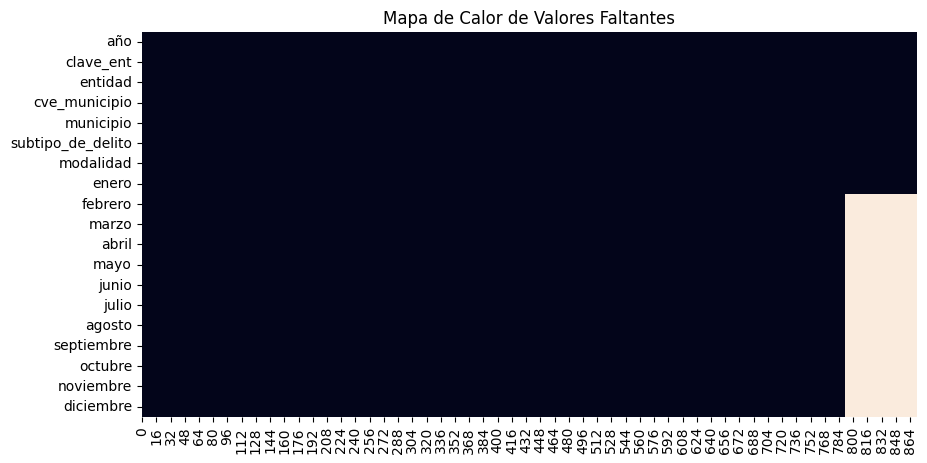

In [20]:
plt.figure(figsize=(10, 5))
sns.heatmap(sampled_pd_df.isna().transpose(), cbar=False)
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

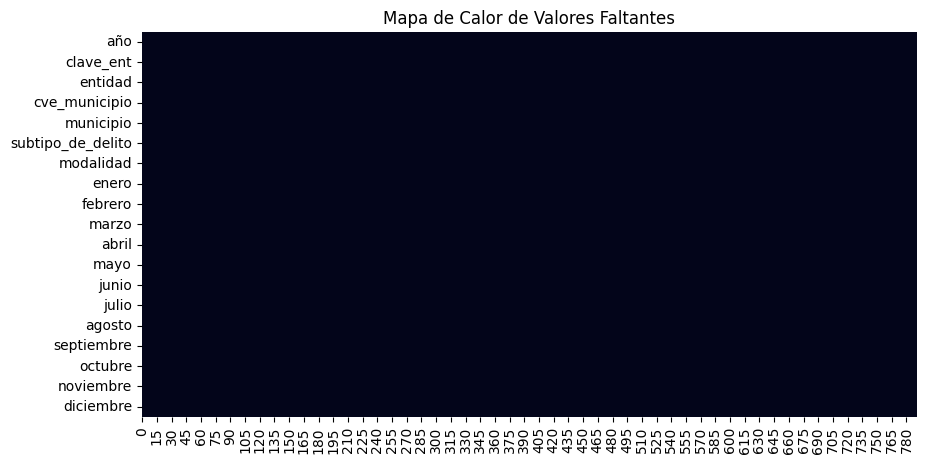

In [21]:
df_filtered = df.filter((df.año < 2024))
sampled_df_filtered = df_filtered.sample(True, 0.001, seed=1234)
sampled_pd_df_filtered = sampled_df_filtered.toPandas()

plt.figure(figsize=(10, 5))
sns.heatmap(sampled_pd_df_filtered.isna().transpose(), cbar=False)
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

Los mapas de calor mostrados anteriormente presentan en el eje y las columnas de nuestro dataframe (o una muestra de este para facilitar el graficado), y en el eje x todos los registros. Marca en negro los registros con datos válidos y en blanco los registros con datos nulos.

Lo que pudimos notar con esta prueba es que justamente los datos que faltan son los registros para los meses más recientes de 2024 (enero y febrero), así como los meses que aún no han pasado (año en curso).

Esto se debe únicamente a la forma en la que se organizan los datos

In [22]:
# Estadísticas descriptivas para las variables numéricas
months = df_filtered.describe(["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"])
months.show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|            enero|           febrero|             marzo|             abril|              mayo|             junio|             julio|            agosto|        septiembre|           octubre|         noviembre|         diciembre|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|           762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|            762516|
|   mean| 0.68130242512944|0.6405727879808424|0.6924

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


months = df_filtered.describe(["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]) \
                   .toPandas() \
                   .set_index('summary') \
                   .transpose() \
                   .rename_axis('months') \
                   .reset_index()

months['count'] = months['count'].astype(int)
months['mean'] = months['mean'].astype(float)
months['stddev'] = months['stddev'].astype(float)
months['min'] = months['min'].astype(int)
months['max'] = months['max'].astype(int)

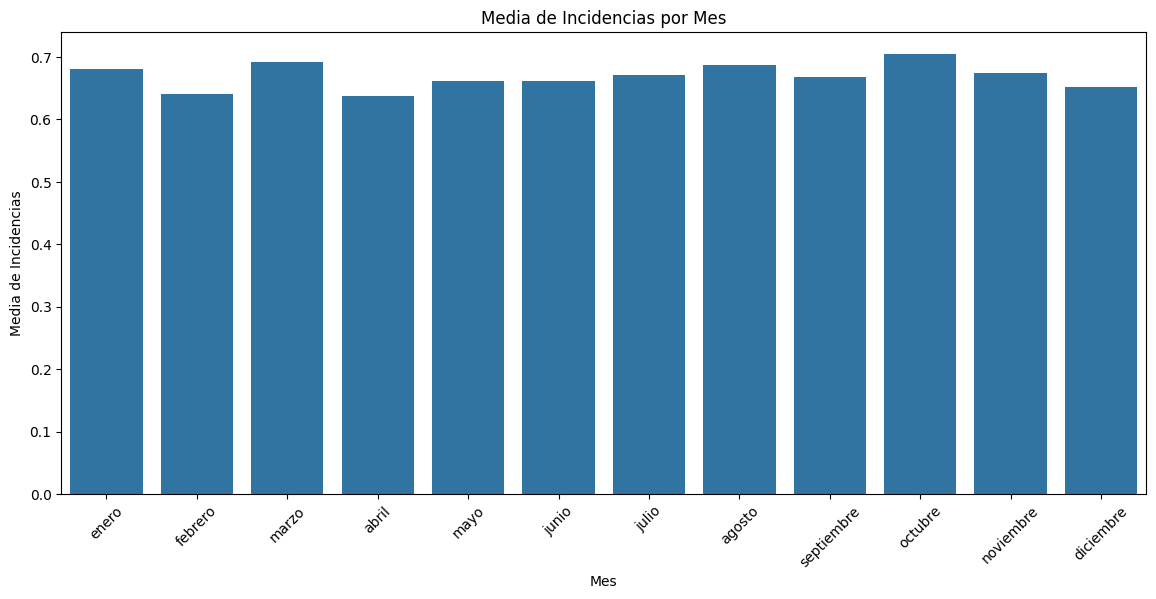

In [24]:
plt.figure(figsize=(14, 6))
sns.barplot(data=months, x='months', y='mean')
plt.xlabel('Mes')
plt.ylabel('Media de Incidencias')
plt.title('Media de Incidencias por Mes')
plt.xticks(rotation=45)
plt.show()


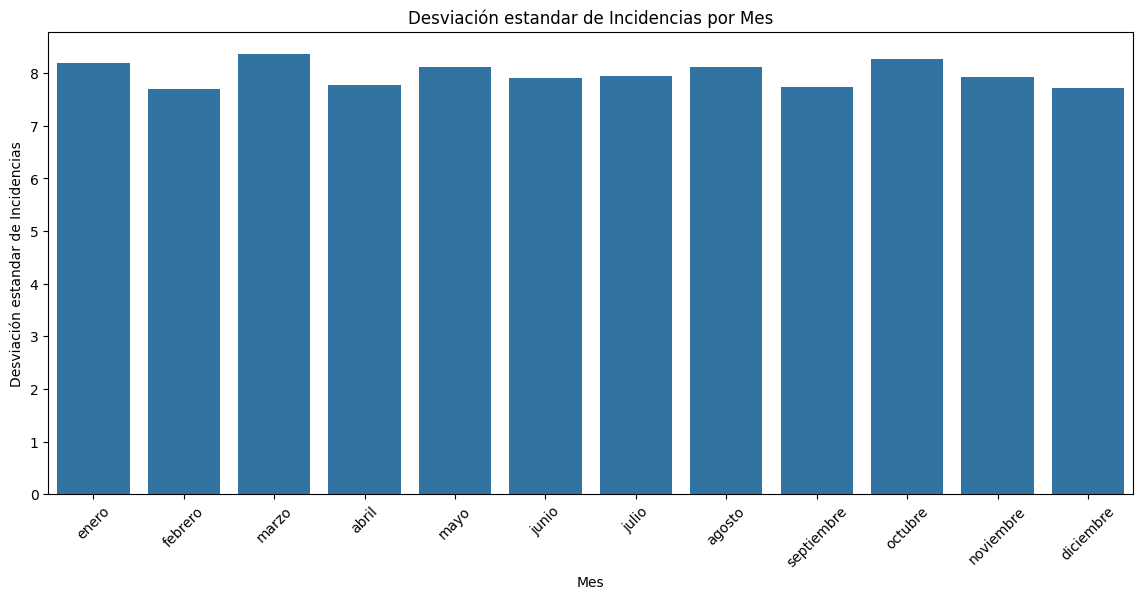

In [25]:
# Crear el gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=months, x='months', y='stddev')
plt.xlabel('Mes')
plt.ylabel('Desviación estandar de Incidencias')
plt.title('Desviación estandar de Incidencias por Mes')
plt.xticks(rotation=45)
plt.show()

Los datos exhiben una distribución bastante uniforme en cada mes, sin diferencias significativas tanto en la media como en la desviación estándar.

Aunque los datos parecen estar en buena forma en general, necesitamos prepararlos para el modelado, con el objetivo de abordar nuestro problema específico.

**Objetivos**:
- Proyectar el comportamiento de los datos para los próximos 3 meses.
- Identificar, basándonos en esta proyección, 3 municipios y 3 tipos de robo para los cuales podríamos considerar aplicar un descuento en el valor del seguro.

Para proyectar el comportamiento de los datos para los próximos 3 meses, es necesario adoptar diferentes enfoques, como el análisis de series temporales. Esto requerirá reestructurar nuestros datos para adecuarlos a este propósito.

In [26]:
meses = df.columns[7:] 

df_reestructurado = df.select(
    col("año"), 
    col("clave_ent"),
    col("entidad"),
    col("cve_municipio"),
    col("municipio"),
    col("subtipo_de_delito"),
    col("modalidad"),
    explode(array(*[array([lit(mes), col(mes)]) for mes in meses])).alias("mes_incidencia"))
df_reestructurado.show(5)

+----+---------+--------------+-------------+--------------+--------------------+-------------+--------------+
| año|clave_ent|       entidad|cve_municipio|     municipio|   subtipo_de_delito|    modalidad|mes_incidencia|
+----+---------+--------------+-------------+--------------+--------------------+-------------+--------------+
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|    [enero, 4]|
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|  [febrero, 3]|
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|    [marzo, 0]|
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|    [abril, 7]|
|2015|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|     [mayo, 4]|
+----+---------+--------------+-------------+--------------+--------------------+-------------+--------------+
o

In [27]:
df_reestructurado = df_reestructurado.select(
    col("año"), 
    col("mes_incidencia")[0].alias('mes'),
    col("clave_ent"),
    col("entidad"),
    col("cve_municipio"),
    col("municipio"),
    col("subtipo_de_delito"),
    col("modalidad"),
    concat(col("año"), lit("-"), get_mes_numerico(col("mes_incidencia")[0])).alias("mes-año"),
    col("mes_incidencia")[1].alias("incidencias")
)
df_reestructurado.show(10)

+----+----------+---------+--------------+-------------+--------------+--------------------+-------------+-------+-----------+
| año|       mes|clave_ent|       entidad|cve_municipio|     municipio|   subtipo_de_delito|    modalidad|mes-año|incidencias|
+----+----------+---------+--------------+-------------+--------------+--------------------+-------------+-------+-----------+
|2015|     enero|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|2015-01|          4|
|2015|   febrero|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|2015-02|          3|
|2015|     marzo|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|2015-03|          0|
|2015|     abril|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|2015-04|          7|
|2015|      mayo|        1|Aguascalientes|         1001|Aguascalientes|Robo a casa habit...|Con violencia|2015-

Podemos además eliminar datos redundantes, por ejemplo `entidad` y `clave_ent` tengo la sospecha que son lo mismo.

In [28]:
temp = df_reestructurado.groupBy('entidad').agg(countDistinct('clave_ent').alias('count'))
if temp.filter(temp['count'] > 1).count() > 0:
    print("Hay valores en la columna 'count' que son mayores que 1.")
else:
    print("No hay valores en la columna 'count' que sean mayores que 1.")
temp.show(5)

No hay valores en la columna 'count' que sean mayores que 1.
+-------------------+-----+
|            entidad|count|
+-------------------+-----+
|   Ciudad de México|    1|
|            Sinaloa|    1|
|Michoacán de Ocampo|    1|
|            Durango|    1|
|           Guerrero|    1|
+-------------------+-----+
only showing top 5 rows



In [29]:
temp = df_reestructurado.groupBy('municipio').agg(countDistinct('cve_municipio').alias('count'))
if temp.filter(temp['count'] > 1).count() > 0:
    print("Hay valores en la columna 'count' que son mayores que 1.")
else:
    print("No hay valores en la columna 'count' que sean mayores que 1.")

temp.filter(temp['count'] > 1).show(5)

Hay valores en la columna 'count' que son mayores que 1.
+--------------+-----+
|     municipio|count|
+--------------+-----+
|       Camargo|    2|
|      Progreso|    2|
|Villa Guerrero|    2|
|      Coatepec|    2|
|Santa Catarina|    3|
+--------------+-----+
only showing top 5 rows



In [30]:
temp = df_reestructurado.groupBy(['entidad', 'municipio']).agg(countDistinct('cve_municipio').alias('count'))
if temp.filter(temp['count'] > 1).count() > 0:
    print("Hay valores en la columna 'count' que son mayores que 1.")
else:
    print("No hay valores en la columna 'count' que sean mayores que 1.")

temp.show(5)

No hay valores en la columna 'count' que sean mayores que 1.
+--------+--------------------+-----+
| entidad|           municipio|count|
+--------+--------------------+-----+
|  Puebla|               Chila|    1|
| Jalisco|         San Gabriel|    1|
|  Puebla|             Piaxtla|    1|
|  Puebla|             Jonotla|    1|
|Guerrero|Atlamajalcingo de...|    1|
+--------+--------------------+-----+
only showing top 5 rows



Con esta pequeña prueba, hemos deducido que `entidad` y `clave_ent` son redundantes, pues su relación es de uno a uno. Lo mismo ocurre con `entidad-municipio` y `cve_municipio`. Podemos eliminar dos columnas entonces. Dado que no quiero que los identificadores se confundan con datos ordenados, eliminaré estas.

In [33]:
clave_ent_dict = dict(df_reestructurado.select('clave_ent', 'entidad').distinct().collect())
clave_municipio_dict = dict(df_reestructurado.select('cve_municipio', 'municipio').distinct().collect())

In [34]:
df_reestructurado = df_reestructurado.drop(col('entidad'), col('municipio'))
df_reestructurado.show(10)

+----+----------+---------+-------------+--------------------+-------------+-------+-----------+
| año|       mes|clave_ent|cve_municipio|   subtipo_de_delito|    modalidad|mes-año|incidencias|
+----+----------+---------+-------------+--------------------+-------------+-------+-----------+
|2015|     enero|        1|         1001|Robo a casa habit...|Con violencia|2015-01|          4|
|2015|   febrero|        1|         1001|Robo a casa habit...|Con violencia|2015-02|          3|
|2015|     marzo|        1|         1001|Robo a casa habit...|Con violencia|2015-03|          0|
|2015|     abril|        1|         1001|Robo a casa habit...|Con violencia|2015-04|          7|
|2015|      mayo|        1|         1001|Robo a casa habit...|Con violencia|2015-05|          4|
|2015|     junio|        1|         1001|Robo a casa habit...|Con violencia|2015-06|          6|
|2015|     julio|        1|         1001|Robo a casa habit...|Con violencia|2015-07|          4|
|2015|    agosto|        1|   

In [36]:
df_reestructurado = df_reestructurado.withColumn('codigo_lugar', concat(df_reestructurado['cve_municipio'], lit('-'), df_reestructurado['clave_ent']))
df_reestructurado.show(10)

+----+----------+---------+-------------+--------------------+-------------+-------+-----------+------------+
| año|       mes|clave_ent|cve_municipio|   subtipo_de_delito|    modalidad|mes-año|incidencias|codigo_lugar|
+----+----------+---------+-------------+--------------------+-------------+-------+-----------+------------+
|2015|     enero|        1|         1001|Robo a casa habit...|Con violencia|2015-01|          4|      1001-1|
|2015|   febrero|        1|         1001|Robo a casa habit...|Con violencia|2015-02|          3|      1001-1|
|2015|     marzo|        1|         1001|Robo a casa habit...|Con violencia|2015-03|          0|      1001-1|
|2015|     abril|        1|         1001|Robo a casa habit...|Con violencia|2015-04|          7|      1001-1|
|2015|      mayo|        1|         1001|Robo a casa habit...|Con violencia|2015-05|          4|      1001-1|
|2015|     junio|        1|         1001|Robo a casa habit...|Con violencia|2015-06|          6|      1001-1|
|2015|    

In [37]:
df_reestructurado = df_reestructurado.drop(col('clave_ent'), col('cve_municipio'))
df_reestructurado.show(10)

+----+----------+--------------------+-------------+-------+-----------+------------+
| año|       mes|   subtipo_de_delito|    modalidad|mes-año|incidencias|codigo_lugar|
+----+----------+--------------------+-------------+-------+-----------+------------+
|2015|     enero|Robo a casa habit...|Con violencia|2015-01|          4|      1001-1|
|2015|   febrero|Robo a casa habit...|Con violencia|2015-02|          3|      1001-1|
|2015|     marzo|Robo a casa habit...|Con violencia|2015-03|          0|      1001-1|
|2015|     abril|Robo a casa habit...|Con violencia|2015-04|          7|      1001-1|
|2015|      mayo|Robo a casa habit...|Con violencia|2015-05|          4|      1001-1|
|2015|     junio|Robo a casa habit...|Con violencia|2015-06|          6|      1001-1|
|2015|     julio|Robo a casa habit...|Con violencia|2015-07|          4|      1001-1|
|2015|    agosto|Robo a casa habit...|Con violencia|2015-08|          3|      1001-1|
|2015|septiembre|Robo a casa habit...|Con violencia|20

En este punto Podemos pasar a explorar y vizualizar los datos en busca de información valiosa para nuestro problema